In [32]:
import json

input_path = "teacher_dataset4.jsonl"

with open(input_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        try:
            json.loads(line)
        except json.JSONDecodeError as e:
            print(f"❌ 第 {i} 行格式错误：{e}")
            print(f"内容片段：{line[:200]}...\n")
            break


FileNotFoundError: [Errno 2] No such file or directory: 'teacher_dataset4.jsonl'

In [23]:
import json

input_path = "teacher_dataset4.jsonl"
output_path = "teacher_dataset4.json"

with open(input_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)


样本总数: 1199
平均长度: 1598.54
最短样本长度: 787
最长样本长度: 3217
90% 样本长度分位: 2098
95% 样本长度分位: 2327


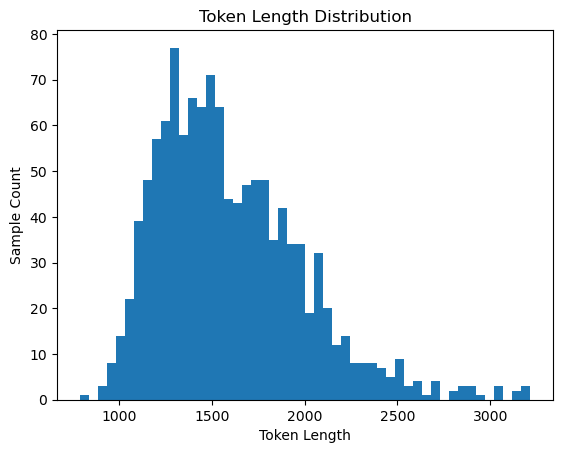

In [54]:
import json
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt

dataset_path = "teacher_dataset.json"  # 替换为你的文件路径
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct", trust_remote_code=True)

token_lengths = []

# 读取整个文件
with open(dataset_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 文件是单个对象或列表
samples = data if isinstance(data, list) else [data]

for sample in samples:
    question = sample.get("question", "")
    docs = [doc.get("content", "") for doc in sample.get("documents", [])]
    teacher_answer = sample.get("teacher_answer", "")
    
    full_text = " ".join([question] + docs + [teacher_answer])
    
    # 用 tokenizer 统计 token 数
    tokens = tokenizer(full_text, truncation=False)["input_ids"]
    token_lengths.append(len(tokens))

# 统计长度分布
counter = Counter(token_lengths)
most_common_lengths = counter.most_common(20)

# --- 分析 ---
print(f"样本总数: {len(token_lengths)}")
print(f"平均长度: {sum(token_lengths)/len(token_lengths):.2f}")
print(f"最短样本长度: {min(token_lengths)}")
print(f"最长样本长度: {max(token_lengths)}")

# 90% / 95% 分位长度
import numpy as np
p90 = int(np.percentile(token_lengths, 90))
p95 = int(np.percentile(token_lengths, 95))
print(f"90% 样本长度分位: {p90}")
print(f"95% 样本长度分位: {p95}")

# --- 可视化 ---
plt.hist(token_lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Sample Count")
plt.show()


样本总数: 1199
平均长度: 636.36
最短样本长度: 386
最长样本长度: 1114
90% 样本长度分位: 768
95% 样本长度分位: 820


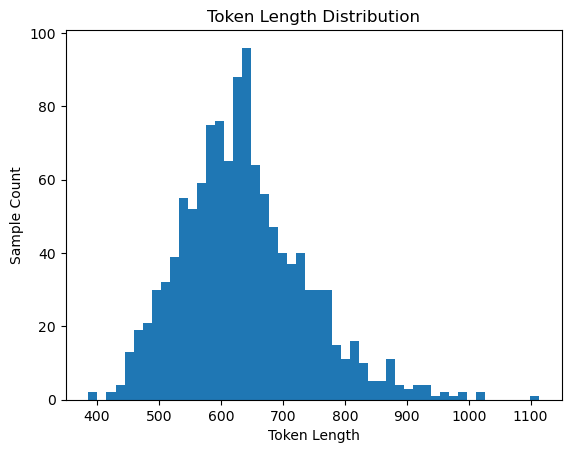

In [51]:
import json
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt

# --- 配置 ---
dataset_path = "teacher_dataset.json"  # 或者 .jsonl
text_field = "teacher_answer"  # 数据集中包含文本的字段
model_name = "Qwen/Qwen2.5-7B-Instruct"  # 和你的模型一致
cache_dir = None

# --- 初始化分词器 ---
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir, trust_remote_code=True)

# --- 读取数据 ---
token_lengths = []

with open(dataset_path, "r", encoding="utf-8") as f:
    # 如果是 jsonl，每行是一个 json 对象
    try:
        for line in f:
            item = json.loads(line)
            text = item.get(text_field, "")
            token_ids = tokenizer(text, add_special_tokens=True)["input_ids"]
            token_lengths.append(len(token_ids))
    except json.JSONDecodeError:
        # 如果是普通 json 列表
        f.seek(0)
        data = json.load(f)
        for item in data:
            text = item.get(text_field, "")
            token_ids = tokenizer(text, add_special_tokens=True)["input_ids"]
            token_lengths.append(len(token_ids))

# --- 分析 ---
print(f"样本总数: {len(token_lengths)}")
print(f"平均长度: {sum(token_lengths)/len(token_lengths):.2f}")
print(f"最短样本长度: {min(token_lengths)}")
print(f"最长样本长度: {max(token_lengths)}")

# 90% / 95% 分位长度
import numpy as np
p90 = int(np.percentile(token_lengths, 90))
p95 = int(np.percentile(token_lengths, 95))
print(f"90% 样本长度分位: {p90}")
print(f"95% 样本长度分位: {p95}")

# --- 可视化 ---
plt.hist(token_lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Sample Count")
plt.show()


In [ ]:
import json
import re

input_path = "teacher_dataset4.json"   # 输入文件
output_path = "teacher_dataset1.json"  # 输出文件


def extract_referenced_indices(answer_text):
    """提取 teacher_answer 中 [Doc1], [Doc3] 这类引用编号"""
    return [int(x) for x in re.findall(r"\[Doc(\d+)\]", answer_text)]


def update_references(answer_text, index_mapping):
    """根据 index_mapping 更新引用编号"""
    def repl(m):
        old_idx = int(m.group(1))
        new_idx = index_mapping.get(old_idx)
        return f"[文档{new_idx}]" if new_idx else ""  # 如果被删就去掉
    return re.sub(r"\[Doc(\d+)\]", repl, answer_text)


with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

processed_data = []

for idx, sample in enumerate(data, 1):
    docs = sample.get("documents", [])
    teacher_answer = sample.get("teacher_answer", "")

    # 提取被引用的编号
    referenced_indices = extract_referenced_indices(teacher_answer)

    # 找出所有 oracle 文档（索引、长度）
    oracle_info = [
        (i, len(d.get("content", "")))
        for i, d in enumerate(docs)
        if d.get("type") == "oracle"
    ]

    # 过滤掉被引用的 oracle
    removable_oracles = [(i, l) for i, l in oracle_info if i + 1 not in referenced_indices]

    # 删除两个 content 最长的 oracle
    to_remove = set(i for i, _ in sorted(removable_oracles, key=lambda x: x[1], reverse=True)[:2])

    # 重新构建 documents
    new_docs = [d for i, d in enumerate(docs) if i not in to_remove]

    # 构建旧编号 -> 新编号映射
    index_mapping = {}
    for new_idx, (old_idx, _) in enumerate([(i, d) for i, d in enumerate(docs) if i not in to_remove], start=1):
        index_mapping[old_idx + 1] = new_idx

    # 更新 teacher_answer 中的引用编号
    new_answer = update_references(teacher_answer, index_mapping)

    # 更新 sample
    sample["documents"] = new_docs
    sample["teacher_answer"] = new_answer
    processed_data.append(sample)

    if idx % 100 == 0:
        print(f"✅ 已处理 {idx} 条样本")

# 保存输出
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=2)

print(f"\n✅ 全部完成，共 {len(processed_data)} 条样本")
print(f"结果已保存到: {output_path}")


✅ 已处理 100 条样本
✅ 已处理 200 条样本
✅ 已处理 300 条样本
✅ 已处理 400 条样本
✅ 已处理 500 条样本
✅ 已处理 600 条样本
✅ 已处理 700 条样本
✅ 已处理 800 条样本
✅ 已处理 900 条样本
✅ 已处理 1000 条样本
✅ 已处理 1100 条样本

✅ 全部完成，共 1199 条样本
结果已保存到: teacher_dataset.json


In [49]:
import json
import re

input_path = "teacher_dataset1.json"   # 输入文件

with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

print(data[0]['teacher_answer'])

- 问题: 如何制定2型糖尿病患者的长期随访计划？
- 假设/已知信息: 患者已被诊断为2型糖尿病，需制定长期管理与随访策略以预防急慢性并发症、维持血糖及其他代谢指标在目标范围内。
- CoT推理:
  1) 症状分析: 2型糖尿病本身常无明显急性症状，但若控制不佳可逐渐出现多饮、多尿、体重下降、疲劳等高血糖表现；更重要的是其慢性并发症风险（如视网膜病变、肾病、神经病变、心血管疾病）和急性并发症风险（如严重高血糖或低血糖）。因此，随访重点在于监测血糖控制水平及靶器官损害迹象。
  2) 鉴别诊断: 此处不涉及新发疾病鉴别，而是针对已有2型糖尿病的病情进展评估。需排除其他类型糖尿病（如LADA、MODY），但假设已确诊为典型2型糖尿病。
  3) 推荐检查: 
     - 血糖相关：HbA1c（每3–6个月一次，目标<7%）；
     - 肾脏功能：每年至少两次检测尿白蛋白排泄率（筛查糖尿病肾病）；
     - 眼科检查：每年进行眼底检查（筛查糖尿病视网膜病变）；
     - 心血管风险评估：血压监测（目标<130/85 mmHg）、血脂谱（LDL-C目标<100 mg/dL）、心电图或心脏风险评分；
     - 足部检查：定期评估感觉、脉搏、皮肤完整性（预防糖尿病足）；
     - 药物副作用监测：如使用SGLT2抑制剂注意泌尿生殖道感染，GLP-1受体激动剂注意胃肠道反应等。
- 初步诊断建议（含不确定度）: 对于已确诊的2型糖尿病患者，应建立结构化长期随访计划，核心包括血糖、血压、血脂达标管理，定期筛查微血管与大血管并发症，并根据个体风险调整治疗方案。该建议基于当前指南，不确定性较低（证据等级高）。
- 证据引用: [文档1] “为了减少大多数微血管并发症, 目标hba1c应小于7%。血压目标应为小于130/85 mmhg。应按照指南规定进行眼底检查, 每年至少两次检查尿白蛋白排泄。ldl胆固醇的目标应小于100 mg/dl。” + Source: StatPearls - Type 2 Diabetes (https://www.ncbi.nlm.nih.gov/books/NBK513253/)
- 不足信息与后续建议: 我不知道患者的具体年龄、病程、是否合并心血管疾病、肾功能状态、当前用药方案、HbA1c水平、是否有低血糖史等关键个体化信息。这

In [48]:
import json
import re

input_path = "teacher_dataset.json"   # 输入文件
output_path = "teacher_dataset1.json"  # 输出文件

def remove_emergency_section(answer_text):
    """
    删除 teacher_answer 中的‘紧急就医指示（红旗症状）’段落
    """
    # 使用正则匹配该部分（从标题开始到句号结尾）
    pattern = r"- 紧急就医指示（红旗症状）:[\s\S]*?(?=(\n- |$))"
    cleaned_text = re.sub(pattern, "", answer_text).strip()
    return cleaned_text


with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

for sample in data:
    if "teacher_answer" in sample:
        sample["teacher_answer"] = remove_emergency_section(sample["teacher_answer"])

# 保存结果
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print(f"✅ 已移除所有样本中的‘紧急就医指示（红旗症状）’部分")
print(f"结果已保存到: {output_path}")


✅ 已移除所有样本中的‘紧急就医指示（红旗症状）’部分
结果已保存到: teacher_dataset1.json


In [4]:
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import spacy

# =============================
# 初始化 NLP 模型
# =============================
try:
    nlp = spacy.load("en_core_sci_sm")
    print("✅ 已成功加载 en_core_sci_sm 模型（SciSpaCy）")
except OSError:
    nlp = spacy.load("en_core_web_sm")
    print("⚠️ 未找到 en_core_sci_sm，已回退至 en_core_web_sm")


# =============================
# 工具函数
# =============================
def extract_medical_entities(text: str):
    """抽取医学相关实体"""
    doc = nlp(text)
    entities = [ent.text.lower() for ent in doc.ents]
    return set(entities)


def calculate_format_score(text: str):
    """判断回答格式是否符合要求"""
    score = 0
    if "诊断" in text: score += 1
    if "处理" in text or "治疗" in text: score += 1
    if "红旗" in text or "就医" in text: score += 1
    return score / 3


def f1(pred, ref):
    """计算F1"""
    if not ref: return 0.0
    tp = len(pred & ref)
    precision = tp / len(pred) if pred else 0
    recall = tp / len(ref)
    return 2 * precision * recall / (precision + recall + 1e-8)


# =============================
# 主函数
# =============================
def evaluate_from_results(result_list):
    """
    根据保存的结果进行量化评估

    Args:
        result_list: 包含 id, question, base_response, tuned_response, teacher_answer 的字典列表
    """
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    bertscore = evaluate.load("bertscore")

    metrics = {
        "rougeL": {"base": [], "tuned": []},
        "bleu": {"base": [], "tuned": []},
        "bertscore": {"base": [], "tuned": []},
        "entity_f1": {"base": [], "tuned": []},
        "format_score": {"base": [], "tuned": []},
        "response_length": {"base": [], "tuned": []}
    }

    for item in tqdm(result_list, desc="Evaluating results"):
        teacher = item.get("teacher_answer", "")
        base_resp = item.get("base_response", "")
        tuned_resp = item.get("tuned_response", "")

        # --- RougeL ---
        metrics["rougeL"]["base"].append(
            rouge.compute(predictions=[base_resp], references=[teacher])["rougeL"]
        )
        metrics["rougeL"]["tuned"].append(
            rouge.compute(predictions=[tuned_resp], references=[teacher])["rougeL"]
        )

        # --- BLEU ---
        metrics["bleu"]["base"].append(
            bleu.compute(predictions=[base_resp.split()], references=[[teacher.split()]])["bleu"]
        )
        metrics["bleu"]["tuned"].append(
            bleu.compute(predictions=[tuned_resp.split()], references=[[teacher.split()]])["bleu"]
        )

        # --- BERTScore ---
        bert_base = bertscore.compute(predictions=[base_resp], references=[teacher], lang="zh")
        bert_tuned = bertscore.compute(predictions=[tuned_resp], references=[teacher], lang="zh")
        metrics["bertscore"]["base"].append(np.mean(bert_base["f1"]))
        metrics["bertscore"]["tuned"].append(np.mean(bert_tuned["f1"]))

        # --- 医学实体一致性 ---
        base_entities = extract_medical_entities(base_resp)
        tuned_entities = extract_medical_entities(tuned_resp)
        ref_entities = extract_medical_entities(teacher)
        metrics["entity_f1"]["base"].append(f1(base_entities, ref_entities))
        metrics["entity_f1"]["tuned"].append(f1(tuned_entities, ref_entities))

        # --- 结构与风格 ---
        metrics["format_score"]["base"].append(calculate_format_score(base_resp))
        metrics["format_score"]["tuned"].append(calculate_format_score(tuned_resp))

        # --- 响应长度 ---
        metrics["response_length"]["base"].append(len(base_resp))
        metrics["response_length"]["tuned"].append(len(tuned_resp))

    # 平均汇总
    results = {}
    for key, value in metrics.items():
        base_mean = np.mean(value["base"])
        tuned_mean = np.mean(value["tuned"])
        improvement = (tuned_mean - base_mean) / (base_mean + 1e-8) * 100
        results[key] = {
            "base": base_mean,
            "tuned": tuned_mean,
            "improvement": improvement
        }

    return results


# =============================
# 报告与可视化
# =============================
def print_comparison_report(results):
    """打印最终报告"""
    print("\n" + "=" * 60)
    print("📊 医学问答模型量化评估报告")
    print("=" * 60)
    for metric, data in results.items():
        print(f"{metric}:")
        print(f"  基础模型: {data['base']:.4f}")
        print(f"  微调模型: {data['tuned']:.4f}")
        print(f"  改进: {data['improvement']:+.2f}%")
        print()

def plot_comparison(results):
    """生成柱状对比图"""
    metrics = list(results.keys())
    base_scores = [results[m]["base"] for m in metrics]
    tuned_scores = [results[m]["tuned"] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, base_scores, width, label='Base Model')
    plt.bar(x + width/2, tuned_scores, width, label='Tuned Model')

    plt.xticks(x, metrics, rotation=30)
    plt.ylabel("Score")
    plt.title("Model Performance Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


ModuleNotFoundError: No module named 'spacy.pipeline.factories'

In [5]:
import spacy
nlp = spacy.load("en_core_sci_sm")
print("✅ SciSpaCy 模型加载成功！")


ModuleNotFoundError: No module named 'spacy.pipeline.factories'

In [21]:
import jieba
import re

def jieba_mixed_tokenize_no_punct(text: str):
    tokens = []
    parts = re.findall(r'[\u4e00-\u9fff]+|[A-Za-z0-9]+', text)
    for part in parts:
        if re.match(r'[\u4e00-\u9fff]+', part):
            tokens.extend(jieba.lcut(part))
        else:
            tokens.append(part)
    return tokens

text = "患者有高血压，currently taking Aspirin 100mg daily。"
tokens = jieba_mixed_tokenize_no_punct(text)
print(tokens)


['患者', '有', '高血压', 'currently', 'taking', 'Aspirin', '100mg', 'daily']


✓ 图表已保存为: training_visualization.png
✓ 详细损失图已保存为: loss_convergence_detailed.png

训练统计信息
初始训练损失: 9.1314
最终训练损失: 4.5512
最佳验证损失: 4.6000 (Step 110)
损失下降: 4.5802 (50.2%)
平均梯度范数: 3.402
总训练步数: 110
总训练时长: ~4小时54分钟
有效样本: 1171 (跳过28个问题样本)


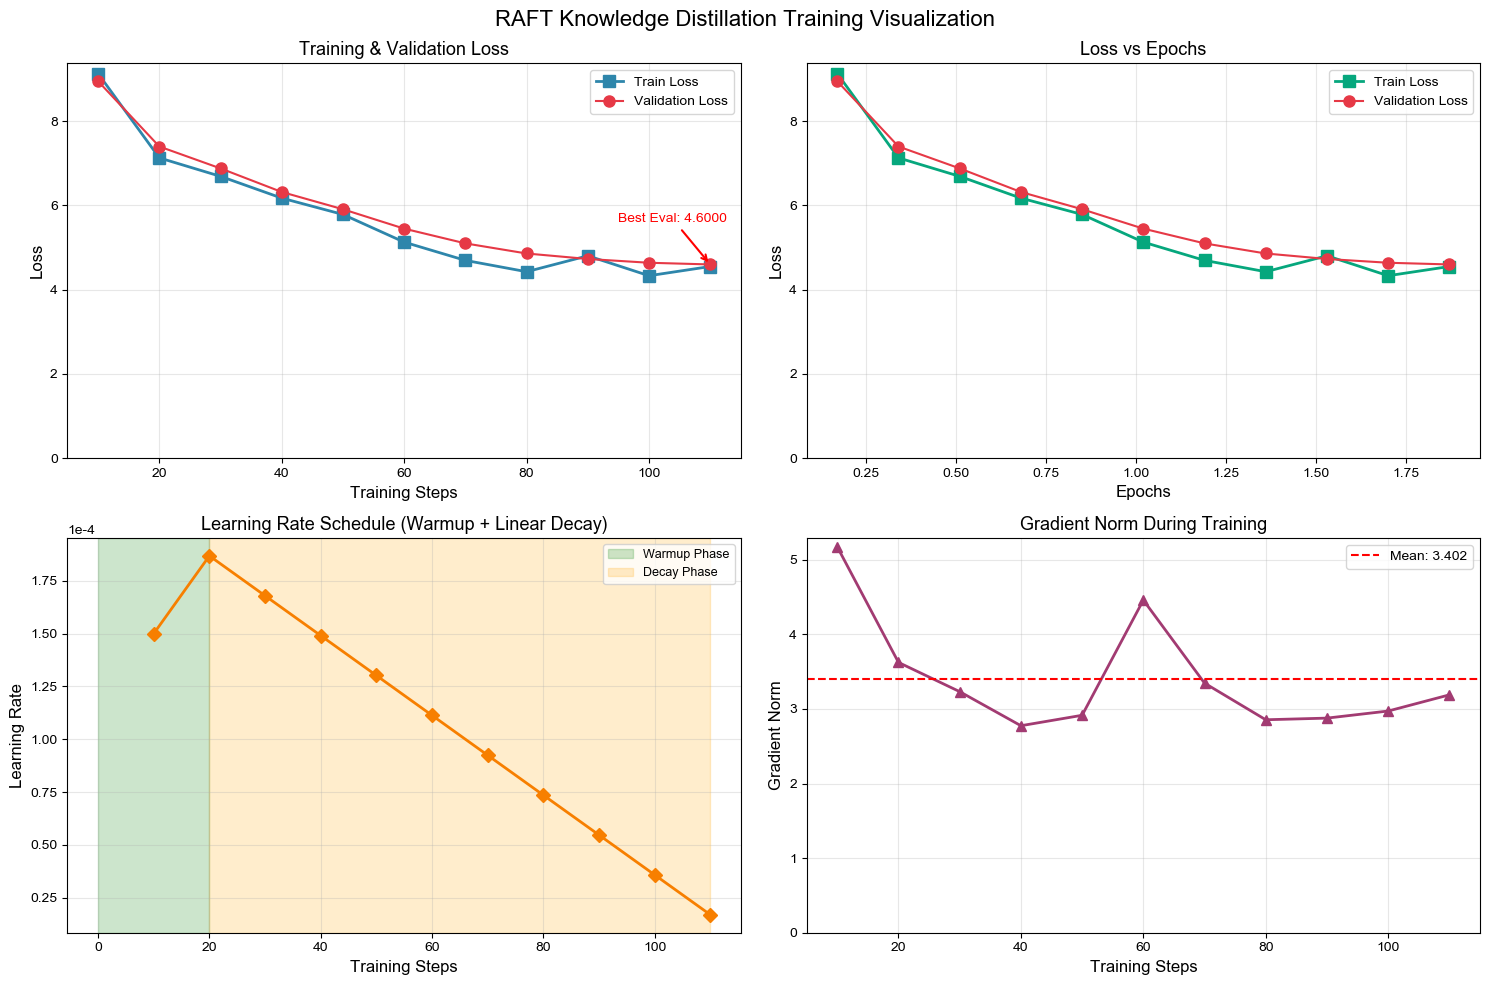

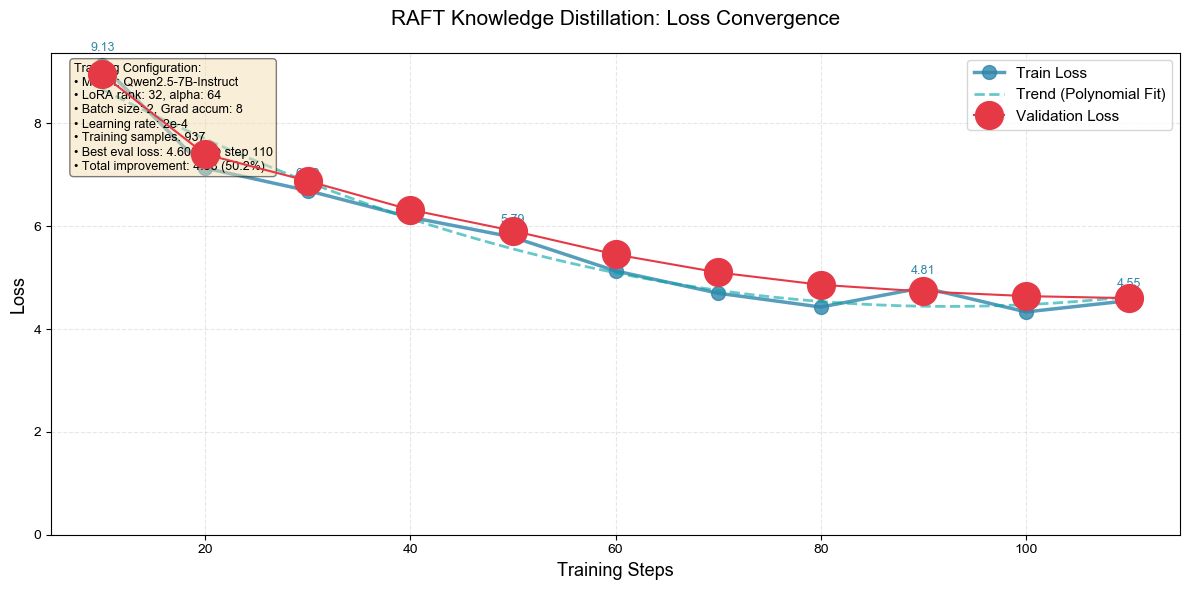

In [30]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# 设置中文字体（防止中文乱码）
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

# ========== 训练数据 ==========
train_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
train_loss = [9.1314, 7.1299, 6.6914, 6.1750, 5.7865, 5.1300, 4.6963, 4.4272, 4.8056, 4.3323, 4.5512]
train_epochs = [0.17, 0.34, 0.51, 0.68, 0.85, 1.02, 1.19, 1.36, 1.53, 1.7, 1.87]

# ========== 验证数据 ==========
eval_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
eval_loss = [8.95, 7.40, 6.88, 6.32, 5.91, 5.45, 5.10, 4.86, 4.73, 4.64, 4.60]
eval_epochs = [0.17, 0.34, 0.51, 0.68, 0.85, 1.02, 1.19, 1.36, 1.53, 1.7, 1.87]

# ========== 学习率和梯度范数 ==========
learning_rates = [
    0.00015, 0.00018679, 0.00016792, 0.00014906, 0.00013019, 
    0.00011132, 0.00009245, 0.00007358, 0.00005472, 0.00003585, 0.00001698
]

grad_norms = [5.174, 3.624, 3.232, 2.775, 2.915, 4.460, 3.346, 2.855, 2.877, 2.972, 3.189]

# ========== 主图表（四宫格） ==========
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('RAFT Knowledge Distillation Training Visualization', fontsize=16, fontweight='bold')

# (1) 训练/验证损失 vs 步数
ax1 = axes[0, 0]
ax1.plot(train_steps, train_loss, 's-', linewidth=2, markersize=8, label='Train Loss', color='#2E86AB')
ax1.plot(eval_steps, eval_loss, 'o-', markersize=8, label='Validation Loss', color='#E63946')
ax1.set_xlabel('Training Steps', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# 自动标出最佳验证点
best_eval_idx = int(np.argmin(eval_loss))
ax1.annotate(f'Best Eval: {eval_loss[best_eval_idx]:.4f}', 
             xy=(eval_steps[best_eval_idx], eval_loss[best_eval_idx]), 
             xytext=(eval_steps[best_eval_idx]-15, eval_loss[best_eval_idx]+1),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, color='red', fontweight='bold')

# (2) 损失 vs Epochs
ax2 = axes[0, 1]
ax2.plot(train_epochs, train_loss, 's-', linewidth=2, markersize=8, label='Train Loss', color='#06A77D')
ax2.plot(eval_epochs, eval_loss, 'o-', markersize=8, label='Validation Loss', color='#E63946')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Loss vs Epochs', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

# (3) 学习率变化
ax3 = axes[1, 0]
ax3.plot(train_steps, learning_rates, 'D-', linewidth=2, markersize=7, color='#F77F00')
ax3.set_xlabel('Training Steps', fontsize=12)
ax3.set_ylabel('Learning Rate', fontsize=12)
ax3.set_title('Learning Rate Schedule (Warmup + Linear Decay)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
ax3.axvspan(0, 20, alpha=0.2, color='green', label='Warmup Phase')
ax3.axvspan(20, 110, alpha=0.2, color='orange', label='Decay Phase')
ax3.legend(fontsize=9, loc='upper right')

# (4) 梯度范数
ax4 = axes[1, 1]
ax4.plot(train_steps, grad_norms, '^-', linewidth=2, markersize=7, color='#A23B72')
ax4.axhline(y=np.mean(grad_norms), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {np.mean(grad_norms):.3f}')
ax4.set_xlabel('Training Steps', fontsize=12)
ax4.set_ylabel('Gradient Norm', fontsize=12)
ax4.set_title('Gradient Norm During Training', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('training_visualization.png', dpi=300, bbox_inches='tight')
print("✓ 图表已保存为: training_visualization.png")

# ========== 第二个图表：详细损失趋势 ==========
fig2, ax = plt.subplots(figsize=(12, 6))

# 绘制训练损失与趋势线
ax.plot(train_steps, train_loss, 'o-', linewidth=2.5, markersize=10, label='Train Loss', color='#2E86AB', alpha=0.8)
z = np.polyfit(train_steps, train_loss, 2)
p = np.poly1d(z)
x_smooth = np.linspace(min(train_steps), max(train_steps), 100)
ax.plot(x_smooth, p(x_smooth), '--', linewidth=2, label='Trend (Polynomial Fit)', color='#00A6A6', alpha=0.6)

# 绘制验证损失
ax.plot(eval_steps, eval_loss, 'o-', markersize=20, label='Validation Loss', color='#E63946', zorder=10)

# 标注部分点
for i, (step, loss) in enumerate(zip(train_steps, train_loss)):
    if i % 2 == 0:
        ax.annotate(f'{loss:.2f}', xy=(step, loss), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontsize=9, color='#2E86AB')

ax.set_xlabel('Training Steps', fontsize=13, fontweight='bold')
ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax.set_title('RAFT Knowledge Distillation: Loss Convergence', fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(bottom=0)

# 添加训练信息文本框
info_text = f"""Training Configuration:
• Model: Qwen2.5-7B-Instruct
• LoRA rank: 32, alpha: 64
• Batch size: 2, Grad accum: 8
• Learning rate: 2e-4
• Training samples: 937
• Best eval loss: {min(eval_loss):.4f} @ step {eval_steps[best_eval_idx]}
• Total improvement: {train_loss[0] - train_loss[-1]:.2f} ({(1-train_loss[-1]/train_loss[0])*100:.1f}%)"""

ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
        fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('loss_convergence_detailed.png', dpi=300, bbox_inches='tight')
print("✓ 详细损失图已保存为: loss_convergence_detailed.png")

# ========== 打印统计信息 ==========
print("\n" + "="*60)
print("训练统计信息")
print("="*60)
print(f"初始训练损失: {train_loss[0]:.4f}")
print(f"最终训练损失: {train_loss[-1]:.4f}")
print(f"最佳验证损失: {min(eval_loss):.4f} (Step {eval_steps[best_eval_idx]})")
print(f"损失下降: {train_loss[0] - train_loss[-1]:.4f} ({(1-train_loss[-1]/train_loss[0])*100:.1f}%)")
print(f"平均梯度范数: {np.mean(grad_norms):.3f}")
print(f"总训练步数: {train_steps[-1]}")
print(f"总训练时长: ~4小时54分钟")
print(f"有效样本: 1171 (跳过28个问题样本)")
print("="*60)

plt.show()
